Date: 02/01/2024

Author: Hoang Van Phan

Here I will analyze Ye lab's scRNA-seq lupus data. The annotated h5ad object was downloaded from cellxgene: https://cellxgene.cziscience.com/collections/436154da-bcf1-4130-9c8b-120ff9a888f2. I will isolate lupus patients.

I will look at physical activity of the patients.

**NOTE:** The object is too big to analyze on a personal laptop. Need about 72GB of RAM.

In [1]:
import numpy as np
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import scanpy as sc
sc.settings.verbosity = 3
sc.logging.print_version_and_date()
import scanpy.external as sce

Running Scanpy 1.9.1, on 2024-02-01 13:45.


In [2]:
# Directory setting
my_dir = "/home/van.phan/langelier_group/Van/20220715_CLUES_lupus/"

# Figure settings
mpl.rcdefaults()
# Set font to be arial
# mpl.rc('font', **{'sans-serif':'Arial', 'size':12})
mpl.rc('font', **{'size':12})
mpl.rcParams['mathtext.rm'] = 'sans' # to have non-italic greek letter, use r'$\mathrm{\alpha}$', does NOT work with f-string
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['pdf.fonttype'] = 42
# Set default tick size
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 2.5
mpl.rcParams['ytick.minor.size'] = 2.5
# Default legend settings
mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.edgecolor'] = 'k'

# sc.settings.set_figure_params(dpi=120)

In [3]:
# Load donor IDs of lupus patients
metadata = pd.read_csv(
    my_dir + "clues_t1_plust2t3PA_N-123_12.7.22.csv")

# Convert number to factor
for i in ["subjectid","inactive_t1","inactive_t3","female","raceeth"]:
    metadata[i] = metadata[i].astype(str)

# # Remove patient 1251: ambiguous sex info
# metadata = metadata.loc[metadata["subjectid"]!="1251",:]
    
# Only keep patients with inactive_t3
metadata = metadata.loc[~metadata["inactive_t3"].isna(),:]

metadata.head()

,subjectid,sampleid_t1,sampleid_t3,rapacomp,inactive_t1,rapamod,rapalight,rapamodlt30,rapaviglt20,rapamodge30,...,dnabloodid,biologicalsex,followupok,acepapertotn,acepaperfinaln,educ3lev,sleflareseverity,inactive_t3,OK,scrnaseq
0,1004,1004DNA01,1004DNA11,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1004DNA01,1,1,1,1,3,0.0,0,1,1
1,1014,1014DNA01,1014DNA11,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1014DNA01,1,1,1,1,3,0.0,0,1,1
2,1015,1015DNA01,.,0.0,nan,NaN,NaN,NaN,NaN,NaN,...,1015DNA01,1,1,1,0,3,0.0,0,1,1
3,1019,.,.,0.0,nan,NaN,NaN,NaN,NaN,NaN,...,1019DNA01,1,1,1,0,3,0.0,0,1,1
4,1022,1022DNA01,1022DNA11,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1022DNA01,1,1,1,1,2,3.0,1,1,1


In [4]:
# Load data
adata = sc.read_h5ad(
    my_dir + "objects/" + "Ye_lab_annotated_cellxgene.h5ad")
adata

AnnData object with n_obs × n_vars = 1263676 × 30933
    obs: 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'cell_state', 'sample_uuid', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'disease_state', 'suspension_enriched_cell_types', 'suspension_uuid', 'suspension_type', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'disease_ontology_term_id', 'sex_ontology_term_id', 'Processing_Cohort', 'ct_cov', 'ind_cov', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: 'default_embedding', 'schema_version', 'title'
    obsm: 'X_pca', 'X_umap'

In [5]:
# Have a look at the object's metadata
print(adata.obs.iloc[0,:])

library_uuid                                3332f018-936e-4c4c-9105-99d9503db5a3
assay_ontology_term_id                                               EFO:0009899
mapped_reference_annotation                                           GENCODE 19
is_primary_data                                                             True
cell_type_ontology_term_id                                            CL:0000624
author_cell_type                                                              T4
cell_state                                                                    na
sample_uuid                                 0a1148dc-356f-4dc4-9c32-bf0823257d93
tissue_ontology_term_id                                           UBERON:0000178
development_stage_ontology_term_id                                HsapDv:0000122
disease_state                                                                 na
suspension_enriched_cell_types                 peripheral blood mononuclear cell
suspension_uuid             

In [6]:
# Isolate CLUES lupus patients: their ind_cov has the format 1234_1234
# Format the subjectid to match ind_cov, and keep patients present in metadata only
my_ind_cov = set([f"{i}_{i}" for i in metadata["subjectid"]])

adata_lupus = adata[adata.obs["ind_cov"].isin(my_ind_cov),:].copy()
adata_lupus # Expected to be "AnnData object with n_obs × n_vars = 597112 × 30933" (according to 20221208_analysis_physact.ipynb)

AnnData object with n_obs × n_vars = 597112 × 30933
    obs: 'library_uuid', 'assay_ontology_term_id', 'mapped_reference_annotation', 'is_primary_data', 'cell_type_ontology_term_id', 'author_cell_type', 'cell_state', 'sample_uuid', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'disease_state', 'suspension_enriched_cell_types', 'suspension_uuid', 'suspension_type', 'donor_id', 'self_reported_ethnicity_ontology_term_id', 'organism_ontology_term_id', 'disease_ontology_term_id', 'sex_ontology_term_id', 'Processing_Cohort', 'ct_cov', 'ind_cov', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: 'default_embedding', 'schema_version', 'title'
    obsm: 'X_pca', 'X_umap'

In [7]:
del adata

# Add subjectid to adata
adata_lupus.obs["subjectid"] = [s.split("_")[1] for s in adata_lupus.obs["ind_cov"]]
adata_lupus.obs.head()

,library_uuid,assay_ontology_term_id,mapped_reference_annotation,is_primary_data,cell_type_ontology_term_id,author_cell_type,cell_state,sample_uuid,tissue_ontology_term_id,development_stage_ontology_term_id,...,ind_cov,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,subjectid
index,,,,,,,,,,,,,,,,,,,,,
CTAACTTCAATGAATG-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0,70a004b7-4a17-4702-8910-4557aa0c4279,EFO:0009899,GENCODE 19,True,CL:0000860,cM,na,577bce84-8d37-4851-9fb4-53f9467699ba,UBERON:0000178,HsapDv:0000139,...,1132_1132,classical monocyte,10x 3' v2,systemic lupus erythematosus,Homo sapiens,female,blood,European,45-year-old human stage,1132
GGCTCGATCGTTGACA-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0-0-0-0-0-0,c2641f62-eb23-4dad-9c22-b52e72b79df2,EFO:0009899,GENCODE 19,True,CL:0000236,B,na,5e0ed28c-a75a-4ecd-a0c7-49e71264690b,UBERON:0000178,HsapDv:0000165,...,1110_1110,B cell,10x 3' v2,systemic lupus erythematosus,Homo sapiens,female,blood,European,71-year-old human stage,1110
ACACCGGCACACAGAG-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,222b358b-71e7-4b0f-9f9b-47b4c67aaa27,EFO:0009899,GENCODE 19,True,CL:0000624,T4,na,982d60b4-5677-4e2d-8b58-79503863710d,UBERON:0000178,HsapDv:0000122,...,1479_1479,"CD4-positive, alpha-beta T cell",10x 3' v2,systemic lupus erythematosus,Homo sapiens,female,blood,Asian,28-year-old human stage,1479
TCGTAGATCCTTGGTC-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0-0-0-0-0-0-0-0-0,0c7c125d-46d6-40ba-8088-31fb2b526a78,EFO:0009899,GENCODE 19,True,CL:0000625,T8,na,fc11ebf7-2767-4d92-96f9-a57af8f1be30,UBERON:0000178,HsapDv:0000146,...,1334_1334,"CD8-positive, alpha-beta T cell",10x 3' v2,systemic lupus erythematosus,Homo sapiens,female,blood,Asian,52-year-old human stage,1334
CCACCTAAGGGCTTCC-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0-0,0955850b-157b-4396-a3da-83b8bcbed172,EFO:0009899,GENCODE 19,True,CL:0000624,T4,na,d1272c4d-f68a-4d3d-bae3-715e337bd80b,UBERON:0000178,HsapDv:0000158,...,1333_1333,"CD4-positive, alpha-beta T cell",10x 3' v2,systemic lupus erythematosus,Homo sapiens,female,blood,Asian,64-year-old human stage,1333


In [8]:
adata_lupus.var.head()

,feature_is_filtered,feature_name,feature_reference,feature_biotype
ENSG00000243485,True,MIR1302-2HG,NCBITaxon:9606,gene
ENSG00000237613,True,FAM138A,NCBITaxon:9606,gene
ENSG00000186092,True,OR4F5,NCBITaxon:9606,gene
ENSG00000238009,True,RP11-34P13.7,NCBITaxon:9606,gene
ENSG00000239945,True,RP11-34P13.8,NCBITaxon:9606,gene


In [9]:
# Use gene name instead of gene symbols
adata_lupus.var = adata_lupus.var.reset_index().set_index("feature_name")
adata_lupus.var_names = adata_lupus.var.index
adata_lupus.var.head()

/hpc/mydata/van.phan/anaconda/2022.05/x86_64/envs/van-conda-env/lib/python3.10/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['MIR1302-2HG', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)
/hpc/mydata/van.phan/anaconda/2022.05/x86_64/envs/van-conda-env/lib/python3.10/site-packages/anndata/_core/anndata.py:895: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['MIR1302-2HG', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


,index,feature_is_filtered,feature_reference,feature_biotype
feature_name,,,,
MIR1302-2HG,ENSG00000243485,True,NCBITaxon:9606,gene
FAM138A,ENSG00000237613,True,NCBITaxon:9606,gene
OR4F5,ENSG00000186092,True,NCBITaxon:9606,gene
RP11-34P13.7,ENSG00000238009,True,NCBITaxon:9606,gene
RP11-34P13.8,ENSG00000239945,True,NCBITaxon:9606,gene


/hpc/mydata/van.phan/anaconda/2022.05/x86_64/envs/van-conda-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/hpc/mydata/van.phan/anaconda/2022.05/x86_64/envs/van-conda-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


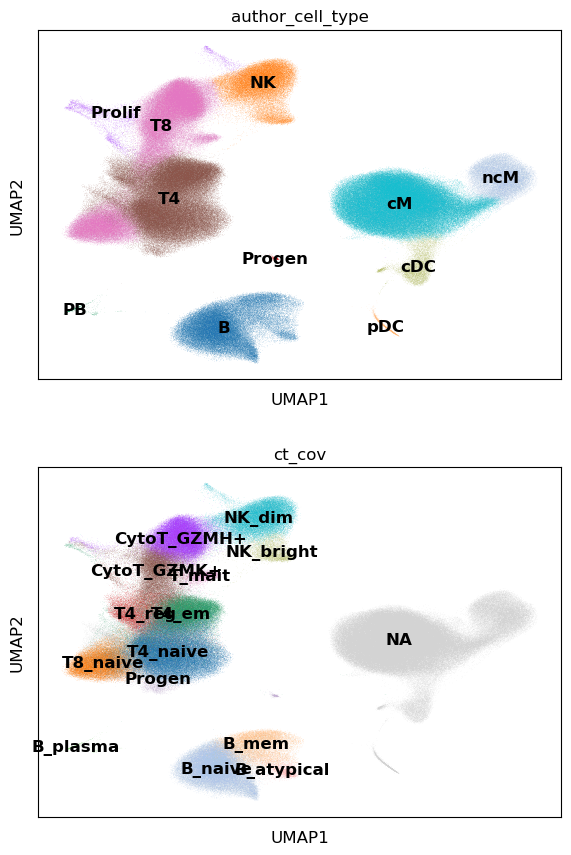

In [10]:
# Plot something to make sure anndata won't change after merging

# UMAP
sc.pl.umap(adata_lupus, color=["author_cell_type","ct_cov"], legend_loc="on data", ncols=1)

In [11]:
# fig.savefig(
#     my_dir + "analysis/"
#     + "20230913_analysis_physact_umap_cell_type.svg",
#     bbox_inches="tight", pad_inches=0
# )

In [12]:
# Merge metadata
adata_lupus.obs = adata_lupus.obs.merge(
    metadata[["subjectid","inactive_t3","raceeth"]].set_index("subjectid"),
    how="left", left_on="subjectid", right_index=True
)
adata_lupus.obs.head()

,library_uuid,assay_ontology_term_id,mapped_reference_annotation,is_primary_data,cell_type_ontology_term_id,author_cell_type,cell_state,sample_uuid,tissue_ontology_term_id,development_stage_ontology_term_id,...,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,subjectid,inactive_t3,raceeth
index,,,,,,,,,,,,,,,,,,,,,
CTAACTTCAATGAATG-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0,70a004b7-4a17-4702-8910-4557aa0c4279,EFO:0009899,GENCODE 19,True,CL:0000860,cM,na,577bce84-8d37-4851-9fb4-53f9467699ba,UBERON:0000178,HsapDv:0000139,...,10x 3' v2,systemic lupus erythematosus,Homo sapiens,female,blood,European,45-year-old human stage,1132,0,1
GGCTCGATCGTTGACA-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0-0-0-0-0-0,c2641f62-eb23-4dad-9c22-b52e72b79df2,EFO:0009899,GENCODE 19,True,CL:0000236,B,na,5e0ed28c-a75a-4ecd-a0c7-49e71264690b,UBERON:0000178,HsapDv:0000165,...,10x 3' v2,systemic lupus erythematosus,Homo sapiens,female,blood,European,71-year-old human stage,1110,0,1
ACACCGGCACACAGAG-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0,222b358b-71e7-4b0f-9f9b-47b4c67aaa27,EFO:0009899,GENCODE 19,True,CL:0000624,T4,na,982d60b4-5677-4e2d-8b58-79503863710d,UBERON:0000178,HsapDv:0000122,...,10x 3' v2,systemic lupus erythematosus,Homo sapiens,female,blood,Asian,28-year-old human stage,1479,0,4
TCGTAGATCCTTGGTC-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0-0-0-0-0-0-0-0-0,0c7c125d-46d6-40ba-8088-31fb2b526a78,EFO:0009899,GENCODE 19,True,CL:0000625,T8,na,fc11ebf7-2767-4d92-96f9-a57af8f1be30,UBERON:0000178,HsapDv:0000146,...,10x 3' v2,systemic lupus erythematosus,Homo sapiens,female,blood,Asian,52-year-old human stage,1334,1,4
CCACCTAAGGGCTTCC-1-1-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-1-0-0-0-0-0-0,0955850b-157b-4396-a3da-83b8bcbed172,EFO:0009899,GENCODE 19,True,CL:0000624,T4,na,d1272c4d-f68a-4d3d-bae3-715e337bd80b,UBERON:0000178,HsapDv:0000158,...,10x 3' v2,systemic lupus erythematosus,Homo sapiens,female,blood,Asian,64-year-old human stage,1333,1,4


In [13]:
adata_lupus.obs["inactive_t3"].value_counts()
# Expected 401751 cells for 0, 195361 cells for 1 (according to 20221208_analysis_physact.ipynb)

0    401751
1    195361
Name: inactive_t3, dtype: int64

/hpc/mydata/van.phan/anaconda/2022.05/x86_64/envs/van-conda-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


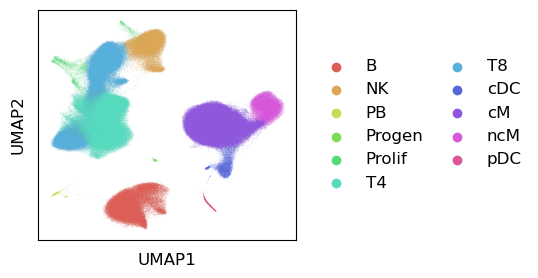

In [14]:
# Save figure
fig, ax = plt.subplots(figsize=(5.6,2.94))
sc.pl.umap(adata_lupus, color=["author_cell_type"], 
           ax=ax, show=False, return_fig=False,
           palette=sns.color_palette("hls",11)) # palette=sns.color_palette("hls", 11)
ax.set_title("")
ax.legend(ncol=2, columnspacing=1,
          loc="center left", bbox_to_anchor=(1.03,0.5),
          frameon=False)
fig.tight_layout()

# fig.savefig(
#     my_dir + "analysis/"
#     + "20221208_analysis_physact_umap_cell_type.pdf",
#     bbox_inches="tight", pad_inches=0
# )
fig.savefig(
    my_dir + "analysis/"
    + "20230913_analysis_physact_umap_cell_type.png",
    dpi=600, bbox_inches="tight", pad_inches=0
)

/hpc/mydata/van.phan/anaconda/2022.05/x86_64/envs/van-conda-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/hpc/mydata/van.phan/anaconda/2022.05/x86_64/envs/van-conda-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


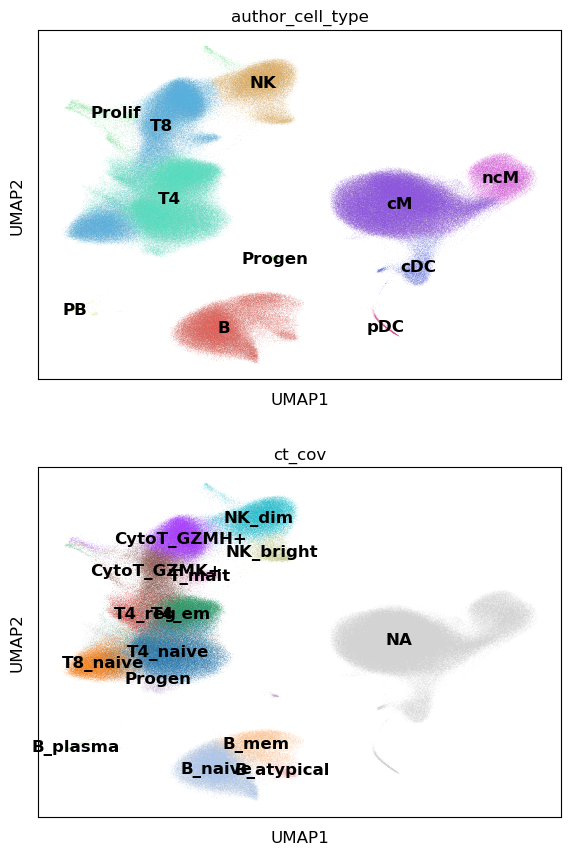

In [15]:
# UMAP
sc.pl.umap(adata_lupus, color=["author_cell_type","ct_cov"], legend_loc="on data", ncols=1)

/hpc/mydata/van.phan/anaconda/2022.05/x86_64/envs/van-conda-env/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/hpc/mydata/van.phan/anaconda/2022.05/x86_64/envs/van-conda-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'inactive_t3'}, xlabel='UMAP1', ylabel='UMAP2'>

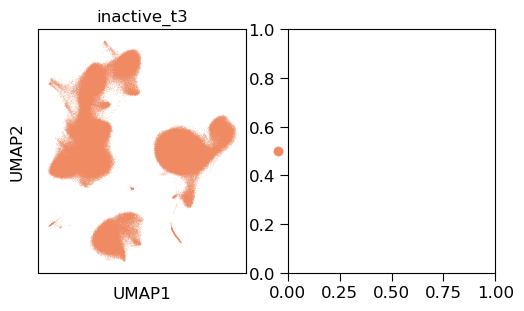

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(5.9,3.16))
sc.pl.umap(adata_lupus[adata_lupus.obs["inactive_t3"]=="0",].copy(),
           color=["inactive_t3"], palette=["#ef8a62"],
           ax=ax[0], show=False, return_fig=False)

/hpc/mydata/van.phan/anaconda/2022.05/x86_64/envs/van-conda-env/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/hpc/mydata/van.phan/anaconda/2022.05/x86_64/envs/van-conda-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/hpc/mydata/van.phan/anaconda/2022.05/x86_64/envs/van-conda-env/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/hpc/mydata/van.phan/anaconda/2022.05/x86_64/envs/van-conda-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


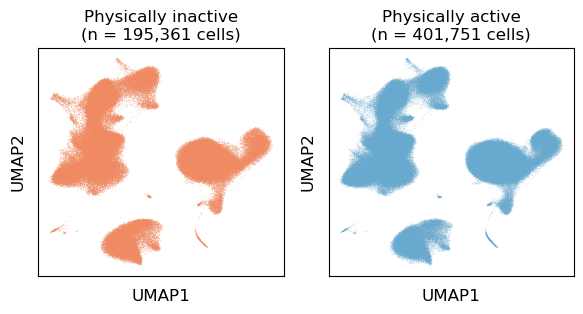

In [17]:
# Save figure
fig, ax = plt.subplots(ncols=2, figsize=(6,3.3))
sc.pl.umap(adata_lupus[adata_lupus.obs["inactive_t3"]=="1",].copy(),
           color=["inactive_t3"], palette=["#ef8a62"],
           ax=ax[0], show=False, return_fig=False)
ax[0].set_title(
    f'Physically inactive\n(n = {(adata_lupus.obs["inactive_t3"]=="1").sum():,} cells)')
ax[0].get_legend().remove()
sc.pl.umap(adata_lupus[adata_lupus.obs["inactive_t3"]=="0",].copy(),
           color=["inactive_t3"], palette=["#67a9cf"],
           ax=ax[1], show=False, return_fig=False)
ax[1].set_title(
    f'Physically active\n(n = {(adata_lupus.obs["inactive_t3"]=="0").sum():,} cells)')
ax[1].get_legend().remove()
fig.tight_layout(w_pad=1)

fig.savefig(
    my_dir + "analysis/"
    + "20230913_analysis_physact_umap_inactive-t3.png",
    dpi=600, bbox_inches="tight", pad_inches=0
)

# Cell type proportions

## Broad annotation (author_cell_type)

In [68]:
cell_prop = adata_lupus.obs.groupby(["subjectid","author_cell_type"]).size()/adata_lupus.obs.groupby(["subjectid"]).size()
cell_prop.name = "prop"
cell_prop.head()

subjectid  author_cell_type
1004       B                   0.016399
           NK                  0.035810
           PB                  0.000000
           Progen              0.001004
           Prolif              0.041499
Name: prop, dtype: float64

In [69]:
cell_prop = pd.DataFrame(cell_prop).reset_index()
cell_prop.head()

,subjectid,author_cell_type,prop
0,1004,B,0.016399
1,1004,NK,0.035810
2,1004,PB,0.000000
3,1004,Progen,0.001004
4,1004,Prolif,0.041499


In [70]:
# Add inactive_t3 info
cell_prop = cell_prop.merge(metadata[["subjectid","inactive_t3","biologicalsex","race"]], how="left",
                            left_on="subjectid", right_on="subjectid")
cell_prop.head()

,subjectid,author_cell_type,prop,inactive_t3,biologicalsex,race
0,1004,B,0.016399,0,1,1
1,1004,NK,0.035810,0,1,1
2,1004,PB,0.000000,0,1,1
3,1004,Progen,0.001004,0,1,1
4,1004,Prolif,0.041499,0,1,1


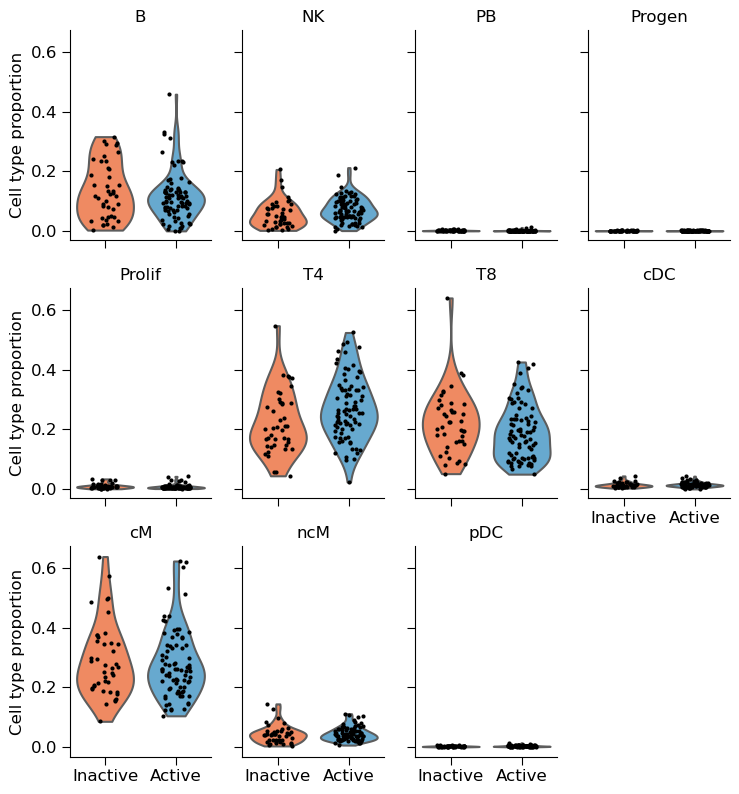

In [21]:
# Plot: violin + jitter
np.random.seed(0)
g = sns.catplot(
    x="inactive_t3", y="prop", col="author_cell_type", col_wrap=4,
    data=cell_prop, kind="violin", scale="width",
    saturation=1, order=["1","0"],
    palette={"0":"#67a9cf", "1":"#ef8a62"},
    inner=None, cut=0,
    height=2.7, aspect=0.7
)
g.map(sns.stripplot, "inactive_t3", "prop", color="k", order=["1","0"], size=3, jitter=0.2)
g.set_xlabels("")
g.set_xticklabels(["Inactive","Active"])
g.set_ylabels("Cell type proportion")
g.set_titles(template="{col_name}")
g.tight_layout(w_pad=1.4, h_pad=1.2)

In [22]:
# # Color settings for boxplot
# PROPS = {
#     "boxprops":{'edgecolor':'black'},
#     "medianprops":{'color':'black'},
#     "whiskerprops":{'color':'black'},
#     "capprops":{'color':'black'}
# }

# # Manual plotting: top 6 cell types
# fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(13,3))
# np.random.seed(0)
# for counter, i in enumerate(["T4","T8","B","cM","ncM","NK"]):
#     sns.boxplot(
#         data=cell_prop.loc[cell_prop["author_cell_type"]==i,:],
#         x="inactive_t3", y="prop", ax=ax[counter],
#         width=0.6, linewidth=1,
#         saturation=1, order=["1","0"],
#         palette={"0":"#67a9cf", "1":"#ef8a62"},
#         fliersize=0, **PROPS
#     )
#     sns.stripplot(
#         data=cell_prop.loc[cell_prop["author_cell_type"]==i,:],
#         x="inactive_t3", y="prop", ax=ax[counter],
#         color="k", order=["1","0"], size=3, jitter=0.2
#     )
#     ax[counter].set_xlabel("")
#     ax[counter].set_ylabel("")
#     ax[counter].set_xticklabels(["Inactive","Active"])
#     ax[counter].set_title(i)
#     ax[counter].set_ylim(-0.02,0.67)
# ax[0].set_ylabel("Cell type proportion")
# sns.despine(fig=fig)
# fig.tight_layout(w_pad=1.4)

# fig.savefig(
#     my_dir + "analysis/"
#     + "20230913_analysis_physact_top6-cell-type_inactive-t3.pdf",
#     bbox_inches="tight", pad_inches=0
# )

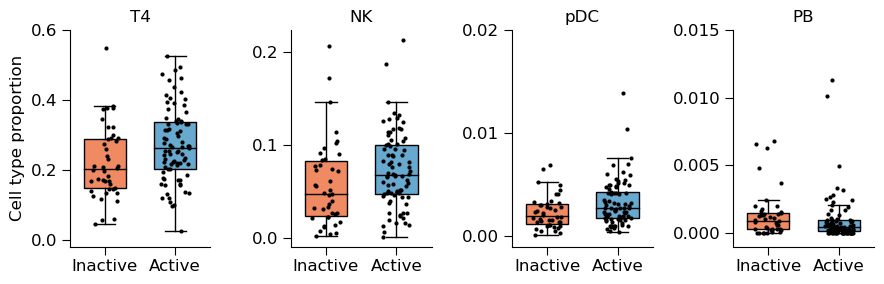

In [28]:
# Color settings for boxplot
PROPS = {
    "boxprops":{'edgecolor':'black'},
    "medianprops":{'color':'black'},
    "whiskerprops":{'color':'black'},
    "capprops":{'color':'black'}
}

# Manual plotting: top 6 cell types
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(9,3))
np.random.seed(0)
for counter, i in enumerate(["T4","NK","pDC","PB"]):
    sns.boxplot(
        data=cell_prop.loc[cell_prop["author_cell_type"]==i,:],
        x="inactive_t3", y="prop", ax=ax[counter],
        width=0.6, linewidth=1,
        saturation=1, order=["1","0"],
        palette={"0":"#67a9cf", "1":"#ef8a62"},
        fliersize=0, **PROPS
    )
    sns.stripplot(
        data=cell_prop.loc[cell_prop["author_cell_type"]==i,:],
        x="inactive_t3", y="prop", ax=ax[counter],
        color="k", order=["1","0"], size=3, jitter=0.2
    )
    ax[counter].set_xlabel("")
    ax[counter].set_ylabel("")
    ax[counter].set_xticklabels(["Inactive","Active"])
    ax[counter].set_title(i)
ax[0].set_ylim([-0.02,0.6])
ax[1].set_yticks([0,0.1,0.2])
ax[2].set_ylim([-0.001,0.02])
ax[2].set_yticks([0,0.01,0.02])
ax[3].set_ylim([-0.001,0.015])
ax[0].set_ylabel("Cell type proportion")
sns.despine(fig=fig)
fig.tight_layout(w_pad=1.2)

fig.savefig(
    my_dir + "analysis/"
    + "20240201_analysis_physact_top4-cell-type_inactive-t3.pdf",
    bbox_inches="tight", pad_inches=0
)

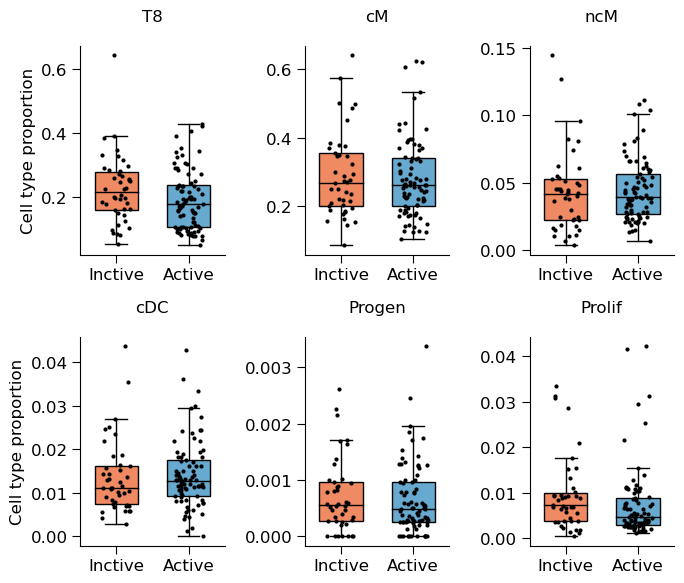

In [35]:
# Color settings for boxplot
PROPS = {
    "boxprops":{'edgecolor':'black'},
    "medianprops":{'color':'black'},
    "whiskerprops":{'color':'black'},
    "capprops":{'color':'black'}
}

# Manual plotting: remaining cell types
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(7,6))
np.random.seed(0)
for counter, i in enumerate(["T8","cM","ncM","cDC","Progen","Prolif"]):
    row = counter // 3
    col = counter % 3
    sns.boxplot(
        data=cell_prop.loc[cell_prop["author_cell_type"]==i,:],
        x="inactive_t3", y="prop", ax=ax[row,col],
        width=0.6, linewidth=1,
        saturation=1, order=["1","0"],
        palette={"0":"#67a9cf", "1":"#ef8a62"},
        fliersize=0, **PROPS
    )
    sns.stripplot(
        data=cell_prop.loc[cell_prop["author_cell_type"]==i,:],
        x="inactive_t3", y="prop", ax=ax[row,col],
        color="k", order=["1","0"], size=3, jitter=0.2
    )
    ax[row,col].set_xlabel("")
    ax[row,col].set_ylabel("")
    ax[row,col].set_xticklabels(["Inctive","Active"])
    ax[row,col].set_title(i, pad=18)
#     ax[counter].set_ylim(-2e-3,0.06)
ax[0,0].set_ylabel("Cell type proportion")
ax[1,0].set_ylabel("Cell type proportion")
sns.despine(fig=fig)
fig.tight_layout(w_pad=1.2)

fig.savefig(
    my_dir + "analysis/"
    + "20240201_analysis_physact_remaining-cell-type_inactive-t3.pdf",
    bbox_inches="tight", pad_inches=0
)

In [29]:
# P-value
pval = []
for i in cell_prop["author_cell_type"].unique():
    print(i)
    print(stats.mannwhitneyu(
        cell_prop.loc[(cell_prop["author_cell_type"]==i) & (cell_prop["inactive_t3"]=="0"),"prop"],
        cell_prop.loc[(cell_prop["author_cell_type"]==i) & (cell_prop["inactive_t3"]=="1"),"prop"]
    ))
    pval.append(stats.mannwhitneyu(
        cell_prop.loc[(cell_prop["author_cell_type"]==i) & (cell_prop["inactive_t3"]=="0"),"prop"],
        cell_prop.loc[(cell_prop["author_cell_type"]==i) & (cell_prop["inactive_t3"]=="1"),"prop"]
    )[1])

B
MannwhitneyuResult(statistic=1494.0, pvalue=0.2707355029237011)
NK
MannwhitneyuResult(statistic=2131.0, pvalue=0.021978457329627346)
PB
MannwhitneyuResult(statistic=1301.0, pvalue=0.03237714503320478)
Progen
MannwhitneyuResult(statistic=1567.5, pvalue=0.4774146818564369)
Prolif
MannwhitneyuResult(statistic=1347.0, pvalue=0.05937670842850975)
T4
MannwhitneyuResult(statistic=2194.0, pvalue=0.008620445906121387)
T8
MannwhitneyuResult(statistic=1376.0, pvalue=0.08350135041900018)
cDC
MannwhitneyuResult(statistic=1873.0, pvalue=0.3603512777177662)
cM
MannwhitneyuResult(statistic=1622.0, pvalue=0.6754499669740508)
ncM
MannwhitneyuResult(statistic=1827.0, pvalue=0.503269207433521)
pDC
MannwhitneyuResult(statistic=2103.5, pvalue=0.032027112728593675)


In [30]:
pval_bh = multipletests(pval, method="fdr_bh")[1]
for counter, value in enumerate(cell_prop["author_cell_type"].unique()):
    print(f"{value}: {pval_bh[counter]}")

B: 0.4254415045943874
NK: 0.08903714884131315
PB: 0.08903714884131315
Progen: 0.5535961281768731
Prolif: 0.13062875854272146
T4: 0.08903714884131315
T8: 0.15308580910150035
cDC: 0.49548300686192853
cM: 0.6754499669740508
ncM: 0.5535961281768731
pDC: 0.08903714884131315


## Fine annotation (ct_cov)

In [36]:
# Prepare a dict for long cell type names
cell_type_dict = {
    "T4_naive":"Naive CD4+ T",
    "T8_naive":"Naive CD8+ T",
    "T4_em":"CD4+ Tem",
    "T4_reg":"CD4+ Treg",
    "CytoT_GZMH+":"GZMH+ CD8+ T",
    "CytoT_GZMK+":"GZMK+ CD8+ T",
    "T_mait":"MAIT",
    "NK_bright":"CD56bright NK",
    "NK_dim":"CD56dim NK",
    "B_naive":"Naive B",
    "B_mem":"Memory B",
    "B_plasma":"Plasma B",
    "B_atypical":"Atypical B",
    "Progen":"Progen"
}

In [37]:
adata_lupus.obs["ct_cov_long"] = adata_lupus.obs["ct_cov"].map(cell_type_dict)

/hpc/mydata/van.phan/anaconda/2022.05/x86_64/envs/van-conda-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


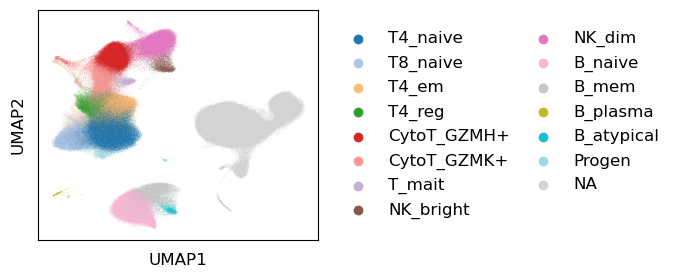

In [39]:
# Save figure
fig, ax = plt.subplots(figsize=(7,2.94))
sc.pl.umap(adata_lupus,
           color=["ct_cov"], 
           ax=ax, show=False, return_fig=False,
           palette="tab20") # palette=sns.color_palette("hls", 11)
ax.set_title("")
ax.legend(ncol=2, columnspacing=1,
          loc="center left", bbox_to_anchor=(1.03,0.5),
          frameon=False)
fig.tight_layout()

# fig.savefig(
#     my_dir + "analysis/"
#     + "20221208_analysis_physact_umap_cell_type.pdf",
#     bbox_inches="tight", pad_inches=0
# )
# fig.savefig(
#     my_dir + "analysis/"
#     + "20230913_analysis_physact_umap_cell_type_fine.png",
#     dpi=600, bbox_inches="tight", pad_inches=0
# )

/hpc/mydata/van.phan/anaconda/2022.05/x86_64/envs/van-conda-env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


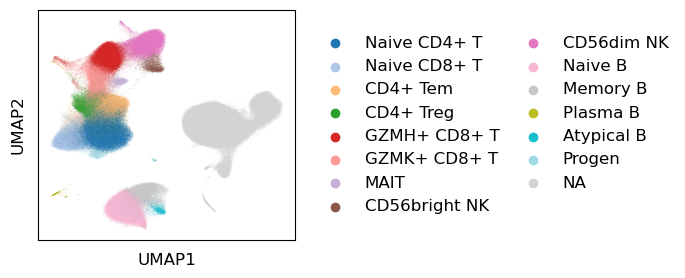

In [41]:
# Save figure
fig, ax = plt.subplots(figsize=(7.1,2.94))
sc.pl.umap(adata_lupus,
           color=["ct_cov_long"], 
           ax=ax, show=False, return_fig=False,
           palette="tab20") # palette=sns.color_palette("hls", 11)
ax.set_title("")
ax.legend(ncol=2, columnspacing=1,
          loc="center left", bbox_to_anchor=(1.03,0.5),
          frameon=False)
fig.tight_layout()

# fig.savefig(
#     my_dir + "analysis/"
#     + "20221208_analysis_physact_umap_cell_type.pdf",
#     bbox_inches="tight", pad_inches=0
# )
fig.savefig(
    my_dir + "analysis/"
    + "20240201_analysis_physact_umap_cell_type_fine.png",
    dpi=600, bbox_inches="tight", pad_inches=0
)

In [42]:
any(adata_lupus.obs["ct_cov"].isna())

True

In [71]:
cell_prop = adata_lupus.obs.groupby(["subjectid","ct_cov"]).size()/adata_lupus.obs.groupby(["subjectid"]).size()
cell_prop.name = "prop"
cell_prop.head()

subjectid  ct_cov     
1004       T4_naive       0.253681
           T8_naive       0.082999
           T4_em          0.107764
           T4_reg         0.051539
           CytoT_GZMH+    0.081325
Name: prop, dtype: float64

In [72]:
cell_prop = pd.DataFrame(cell_prop).reset_index()
cell_prop.head()

,subjectid,ct_cov,prop
0,1004,T4_naive,0.253681
1,1004,T8_naive,0.082999
2,1004,T4_em,0.107764
3,1004,T4_reg,0.051539
4,1004,CytoT_GZMH+,0.081325


In [73]:
# Add inactive_t3 info
cell_prop = cell_prop.merge(metadata[["subjectid","inactive_t3","biologicalsex","race"]], how="left",
                            left_on="subjectid", right_on="subjectid")
cell_prop.head()

,subjectid,ct_cov,prop,inactive_t3,biologicalsex,race
0,1004,T4_naive,0.253681,0,1,1
1,1004,T8_naive,0.082999,0,1,1
2,1004,T4_em,0.107764,0,1,1
3,1004,T4_reg,0.051539,0,1,1
4,1004,CytoT_GZMH+,0.081325,0,1,1


In [74]:
# P-value
pval = []
for i in cell_prop["ct_cov"].unique():
    print(i)
    print(stats.mannwhitneyu(
        cell_prop.loc[(cell_prop["ct_cov"]==i) & (cell_prop["inactive_t3"]=="0"),"prop"],
        cell_prop.loc[(cell_prop["ct_cov"]==i) & (cell_prop["inactive_t3"]=="1"),"prop"]
    ))
    pval.append(stats.mannwhitneyu(
        cell_prop.loc[(cell_prop["ct_cov"]==i) & (cell_prop["inactive_t3"]=="0"),"prop"],
        cell_prop.loc[(cell_prop["ct_cov"]==i) & (cell_prop["inactive_t3"]=="1"),"prop"]
    )[1])
    
# BH correction
pval_bh = multipletests(pval, method="fdr_bh")[1]
pval_bh_dict = {}
for counter, value in enumerate(cell_prop["ct_cov"].unique()):
    pval_bh_dict[value] = pval_bh[counter]

T4_naive
MannwhitneyuResult(statistic=2281.0, pvalue=0.0019964118442567643)
T8_naive
MannwhitneyuResult(statistic=1931.0, pvalue=0.2209374515233562)
T4_em
MannwhitneyuResult(statistic=1783.0, pvalue=0.6637942988337868)
T4_reg
MannwhitneyuResult(statistic=1544.0, pvalue=0.40389037146713624)
CytoT_GZMH+
MannwhitneyuResult(statistic=1234.0, pvalue=0.012843497590477362)
CytoT_GZMK+
MannwhitneyuResult(statistic=1328.0, pvalue=0.04695229849137541)
T_mait
MannwhitneyuResult(statistic=1815.0, pvalue=0.5449083569506272)
NK_bright
MannwhitneyuResult(statistic=1978.0, pvalue=0.1402894886959092)
NK_dim
MannwhitneyuResult(statistic=2117.0, pvalue=0.026686645780693012)
B_naive
MannwhitneyuResult(statistic=1526.0, pvalue=0.35200983044379497)
B_mem
MannwhitneyuResult(statistic=1891.0, pvalue=0.31215973109842476)
B_plasma
MannwhitneyuResult(statistic=1436.0, pvalue=0.1553028411056595)
B_atypical
MannwhitneyuResult(statistic=1273.0, pvalue=0.022585053151076777)
Progen
MannwhitneyuResult(statistic=1808.0

In [75]:
pval_bh

array([0.02794977, 0.38664054, 0.6637943 , 0.51404229, 0.08990448,
       0.13146644, 0.61387052, 0.31060568, 0.09340326, 0.49281376,
       0.4855818 , 0.31060568, 0.09340326, 0.61387052])

In [48]:
# # Color settings for boxplot
# PROPS = {
#     "boxprops":{'edgecolor':'black'},
#     "medianprops":{'color':'black'},
#     "whiskerprops":{'color':'black'},
#     "capprops":{'color':'black'}
# }

# # Manual plotting: top 6 cell types
# fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(12,8.4))
# np.random.seed(0)
# for counter, i in enumerate(adata_lupus.obs["ct_cov"].cat.categories):
#     row = counter // 5
#     col = counter % 5
    
#     sns.boxplot(
#         data=cell_prop.loc[cell_prop["ct_cov"]==i,:],
#         x="inactive_t3", y="prop", ax=ax[row,col],
#         width=0.6, linewidth=1,
#         saturation=1, order=["1","0"],
#         palette={"0":"#67a9cf", "1":"#ef8a62"},
#         fliersize=0, **PROPS
#     )
#     sns.stripplot(
#         data=cell_prop.loc[cell_prop["ct_cov"]==i,:],
#         x="inactive_t3", y="prop", ax=ax[row,col],
#         color="k", order=["1","0"], size=3, jitter=0.2
#     )
#     ax[row,col].set_xlabel("")
#     ax[row,col].set_ylabel("")
#     ax[row,col].set_xticklabels(["Inactive","Active"])
    
#     tmp = pval_bh_dict[i]
#     ax[row,col].set_title(f"{cell_type_dict[i]}\n" + "$\mathregular{P_{adj}}$ = " + f"{tmp:.2g}")
# #     ax[counter].set_ylim(-0.02,0.67)
# ax[0,0].set_ylabel("Cell type proportion")
# ax[1,0].set_ylabel("Cell type proportion")
# ax[2,0].set_ylabel("Cell type proportion")
# ax[-1,-1].axis("off")

# # Manually tweak y limits
# ax[0,1].set_ylim(-0.01,0.2)
# ax[0,2].set_ylim(-0.01,0.25)
# ax[0,3].set_ylim(-0.007,0.15)
# ax[0,4].set_ylim(-0.016,0.4)
# ax[1,0].set_ylim(-0.015,0.3)
# ax[1,1].set_ylim(-0.0015,0.03)
# ax[1,2].set_ylim(-0.002,0.03)
# ax[1,4].set_ylim(-0.02,0.4)
# ax[2,0].set_ylim(-0.01,0.2)
# ax[2,1].set_ylim(-4e-4,0.01)
# ax[2,2].set_ylim(-0.0017, 0.04)

# sns.despine(fig=fig)
# fig.tight_layout(w_pad=1.3, h_pad=1.4)

# fig.savefig(
#     my_dir + "analysis/"
#     + "20230913_analysis_physact_fine-cell-type_inactive-t3.pdf",
#     bbox_inches="tight", pad_inches=0
# )

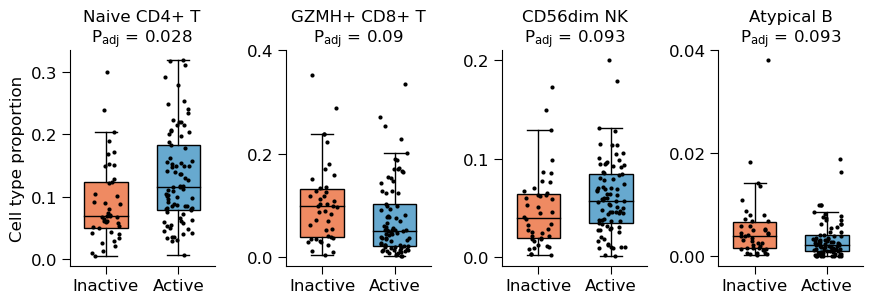

In [55]:
# Color settings for boxplot
PROPS = {
    "boxprops":{'edgecolor':'black'},
    "medianprops":{'color':'black'},
    "whiskerprops":{'color':'black'},
    "capprops":{'color':'black'}
}

# Manual plotting: top 4 cell types
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(9,3.2))
np.random.seed(0)
for counter, i in enumerate(["T4_naive","CytoT_GZMH+","NK_dim","B_atypical"]):
    sns.boxplot(
        data=cell_prop.loc[cell_prop["ct_cov"]==i,:],
        x="inactive_t3", y="prop", ax=ax[counter],
        width=0.6, linewidth=1,
        saturation=1, order=["1","0"],
        palette={"0":"#67a9cf", "1":"#ef8a62"},
        fliersize=0, **PROPS
    )
    sns.stripplot(
        data=cell_prop.loc[cell_prop["ct_cov"]==i,:],
        x="inactive_t3", y="prop", ax=ax[counter],
        color="k", order=["1","0"], size=3, jitter=0.2
    )
    ax[counter].set_xlabel("")
    ax[counter].set_ylabel("")
    ax[counter].set_xticklabels(["Inactive","Active"])
    
    tmp = pval_bh_dict[i]
    ax[counter].set_title(f"{cell_type_dict[i]}\n" + "$\mathregular{P_{adj}}$ = " + f"{tmp:.2g}")
#     ax[counter].set_ylim(-0.02,0.67)
ax[0].set_ylabel("Cell type proportion")

# Manually tweak y limits
ax[1].set_yticks([0,0.2,0.4])
ax[2].set_yticks([0,0.1,0.2])
ax[3].set_yticks([0,0.02,0.04])

sns.despine(fig=fig)
fig.tight_layout(w_pad=1.3)

fig.savefig(
    my_dir + "analysis/"
    + "20240201_analysis_physact_top4-fine-cell-type_inactive-t3.pdf",
    bbox_inches="tight", pad_inches=0
)

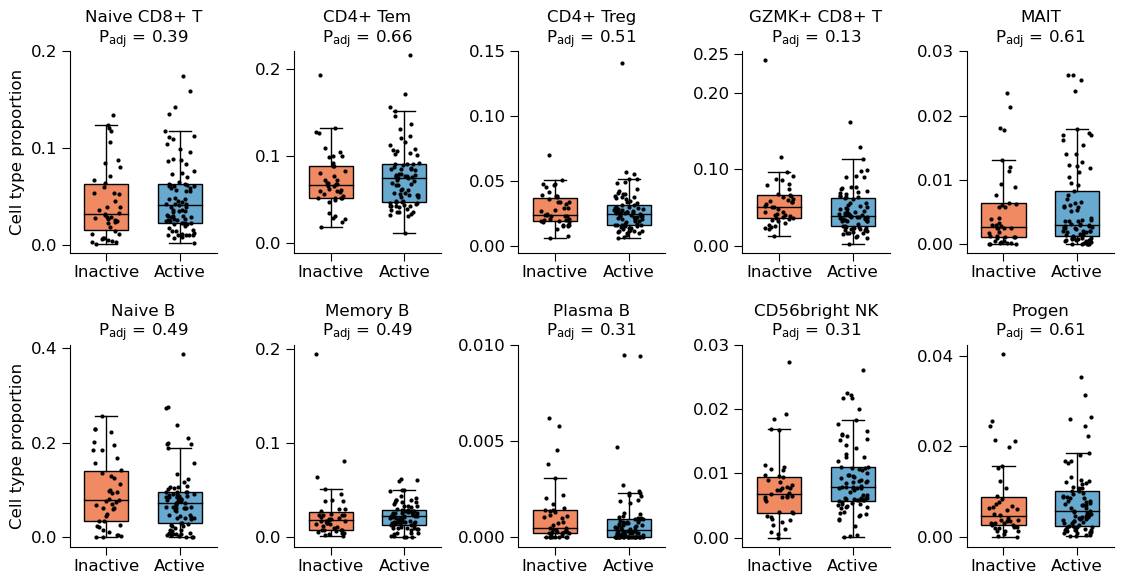

In [103]:
# Color settings for boxplot
PROPS = {
    "boxprops":{'edgecolor':'black'},
    "medianprops":{'color':'black'},
    "whiskerprops":{'color':'black'},
    "capprops":{'color':'black'}
}

# Manual plotting: remaining cell types
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(11.4,6))
np.random.seed(0)
# temp = set(adata_lupus.obs["ct_cov"].cat.categories).difference({"T4_naive","CytoT_GZMH+","NK_dim","B_atypical"})
# temp = list(temp)
temp.sort()
for counter, i in enumerate(["T8_naive","T4_em","T4_reg","CytoT_GZMK+","T_mait","B_naive","B_mem","B_plasma","NK_bright","Progen"]):
    row = counter // 5
    col = counter % 5
    
    sns.boxplot(
        data=cell_prop.loc[cell_prop["ct_cov"]==i,:],
        x="inactive_t3", y="prop", ax=ax[row,col],
        width=0.6, linewidth=1,
        saturation=1, order=["1","0"],
        palette={"0":"#67a9cf", "1":"#ef8a62"},
        fliersize=0, **PROPS
    )
    sns.stripplot(
        data=cell_prop.loc[cell_prop["ct_cov"]==i,:],
        x="inactive_t3", y="prop", ax=ax[row,col],
        color="k", order=["1","0"], size=3, jitter=0.2
    )
    ax[row,col].set_xlabel("")
    ax[row,col].set_ylabel("")
    ax[row,col].set_xticklabels(["Inactive","Active"])
    
    tmp = pval_bh_dict[i]
    ax[row,col].set_title(f"{cell_type_dict[i]}\n" + "$\mathregular{P_{adj}}$ = " + f"{tmp:.2g}")

for i in range(2):
    ax[i,0].set_ylabel("Cell type proportion")
    ax[i,0].set_ylabel("Cell type proportion")

# Manually tweak y limits
ax[0,0].set_yticks([0,0.1,0.2])
ax[0,1].set_yticks([0,0.1,0.2])
ax[0,1].set_ylim([-0.1/9,0.22])
ax[0,2].set_yticks(np.arange(0,0.16,0.05))
ax[0,2].set_ylim([-0.005,0.15])
ax[0,3].set_yticks([0,0.1,0.2,0.25])
ax[0,4].set_yticks(np.arange(0,0.031,0.01))
ax[1,0].set_yticks([0,0.2,0.4])
ax[1,1].set_yticks([0,0.1,0.2])
ax[1,2].set_yticks([0,0.005,0.01])
ax[1,3].set_yticks(np.arange(0,0.031,0.01))
ax[1,4].set_yticks([0,0.02,0.04])

sns.despine(fig=fig)
fig.tight_layout(w_pad=1, h_pad=1.4)

fig.savefig(
    my_dir + "analysis/"
    + "20240201_analysis_physact_remaining-fine-cell-type_inactive-t3.pdf",
    bbox_inches="tight", pad_inches=0
)

In [ ]:
plt.hist(pval)

In [ ]:
!conda list -n van-conda-env